# Bias & Fairness: Modeling Recidivism¶

### Loading Libraries & Data¶

In [53]:
# Numerical Manipulation
import numpy as np
# Data Management
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Bias Measurement
from sklearn.metrics import classification_report

import dalex as dx

In [2]:
compas_df = pd.read_csv('/work/compas-scores-two-years.csv')
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


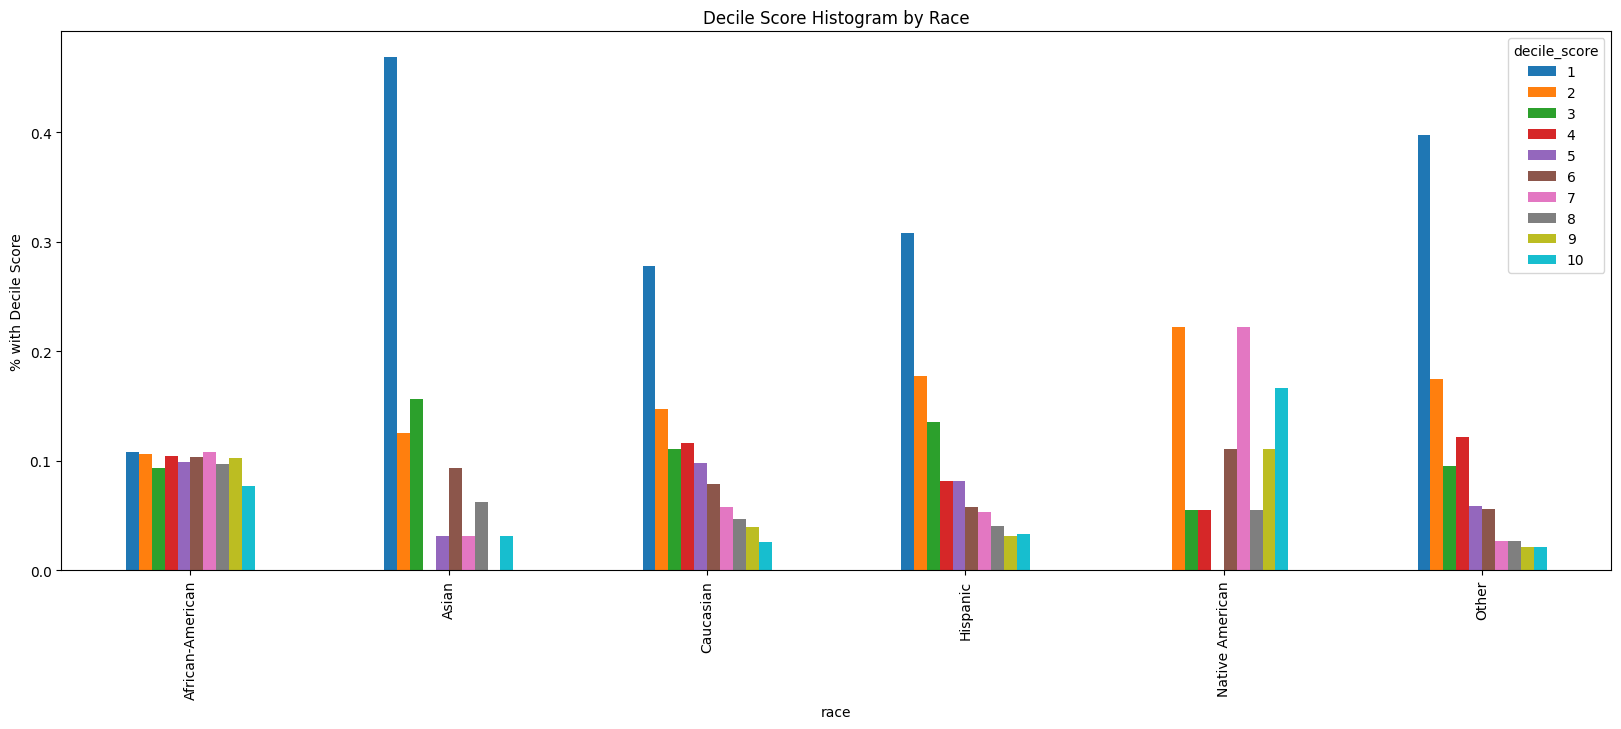

In [4]:
compas_df.groupby('race')['decile_score'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(20, 7),
    title='Decile Score Histogram by Race', ylabel='% with Decile Score')

plt.show()

In [5]:
# Courts generally use  a decile score of 5 to label someone as being medium risk.
compas_df['is_med_or_high_risk'] = (compas_df['decile_score']>=5).astype(bool)

In [6]:
# Not great if the court's system of 5 or higher on the decile score is only accurate 65% of the time
(compas_df['is_med_or_high_risk']==compas_df['two_year_recid']).mean()

0.6537288605489326

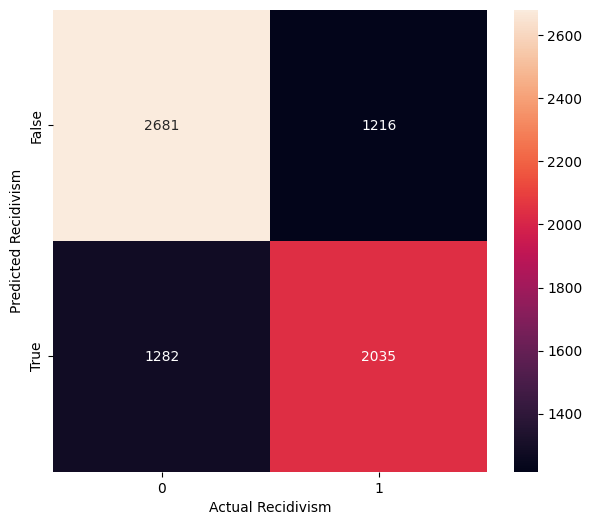

In [7]:
# Recidivism HeatMap
cm = pd.crosstab(
    compas_df['is_med_or_high_risk'], compas_df['two_year_recid'], 
    rownames=['Predicted Recidivism'], colnames=['Actual Recidivism']
)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(cm, annot=True, fmt='d')

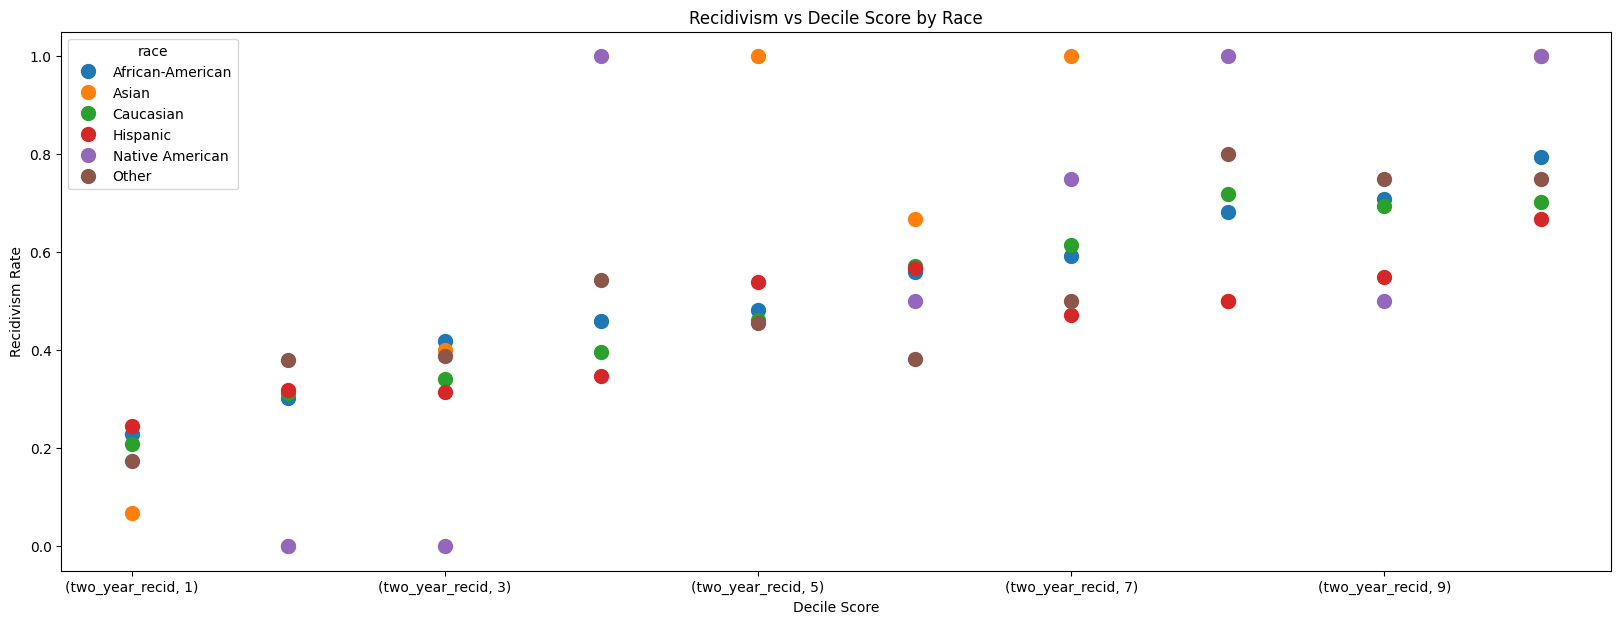

In [8]:
# scatter plot 
compas_df.groupby(
    ['race', 'decile_score']
)[['two_year_recid']].mean().unstack().T.plot(
    xlabel='Decile Score', ylabel='Recidivism Rate', title='Recidivism vs Decile Score by Race',
    style='.', figsize=(20, 7),
    ms=20
)

plt.show()

## Exploratory Data Analysis

In [9]:
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


In [10]:
# Relabel rows with Asian/Native American races as Other
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

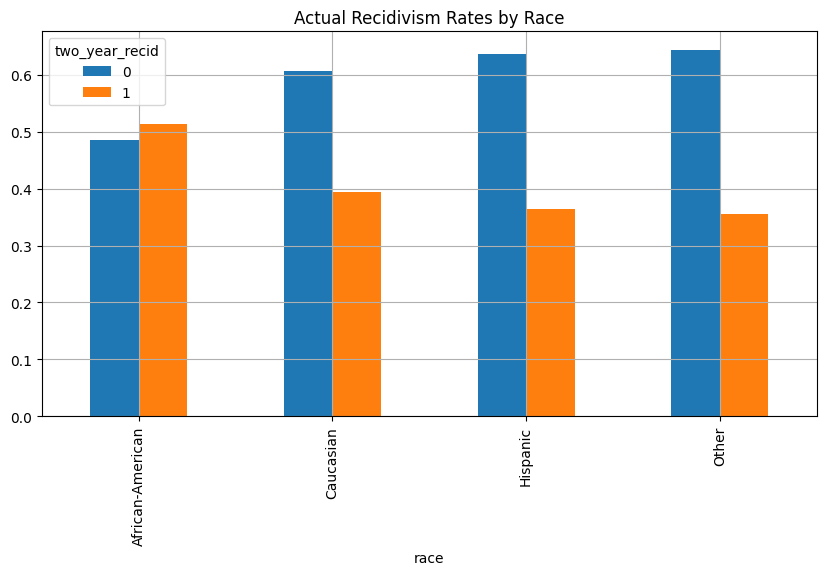

In [11]:
# Plot recidivism rates from the four races we are considering
compas_df.groupby('race')['two_year_recid'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(10, 5), title='Actual Recidivism Rates by Race')

plt.grid(True)
plt.show()

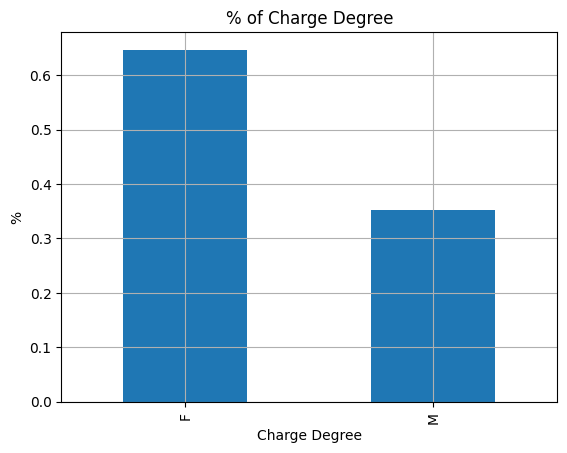

In [12]:
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
    kind='bar', title='% of Charge Degree', ylabel= '%', xlabel='Charge Degree')

plt.grid(True)
plt.show()

### Plotting on Quantitative Variables

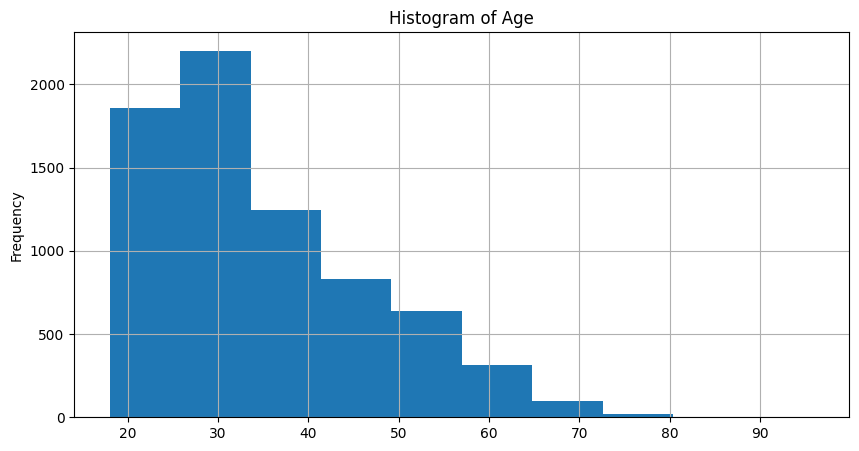

In [13]:
# Right skew on Age
compas_df['age'].plot(
    title='Histogram of Age', kind='hist', xlabel='Age', figsize=(10, 5)
)

plt.grid(True)
plt.show()

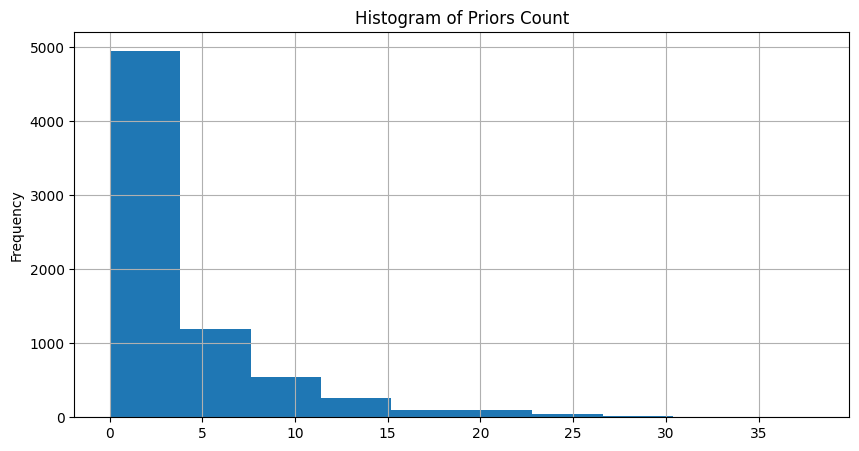

In [14]:
#Right skew on Priors
compas_df['priors_count'].plot(
    title='Histogram of Priors Count', kind='hist', xlabel='Priors', figsize=(10, 5)
)

plt.grid(True)
plt.show()

## Building a Baseline Model

### Feature Construction

In [15]:
compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].describe()

,juv_fel_count,juv_misd_count,juv_other_count
count,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371
std,0.473972,0.485239,0.501586
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000


In [16]:
# New Total Juvenile Offense Count
compas_df['juv_count'] = compas_df[["juv_fel_count", "juv_misd_count", "juv_other_count"]].sum(axis=1)

In [17]:
# Removing the Original Juvenile Feature
compas_df = compas_df.drop(["juv_fel_count", "juv_misd_count", "juv_other_count"], axis=1)

### Building our Baseline Pipeline

In [18]:
# Split up our data 
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(compas_df.drop('two_year_recid', axis=1),
                                                    compas_df['two_year_recid'],
                                                    compas_df['race'],
                                                    stratify=compas_df['two_year_recid'],
                                                    test_size=0.3,
                                                    random_state=0)

# our static classifier
classifier = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

In [19]:
# Qualitative Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
    
])

In [20]:
# Quantitative Pipeline
numerical_features = ['age', 'priors_count']
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

In [21]:
# Merging on One Feature PreProcessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [22]:
clf_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['race', 'sex',
                                                   'c_charge_degree']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'priors_count'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=20,
                                        random_state=0))])

In [23]:
unaware_y_preds = clf_tree.predict(X_test)

### Measuring Bias on Baseline Model

In [24]:
exp_tree = dx.Explainer(
    clf_tree, X_test, y_test,
    label='Random Forest Bias Unaware', verbose=True)

Preparation of a new explainer is initiated

  -> data              : 2165 rows 51 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2165 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Bias Unaware
  -> predict function  : <function yhat_proba_default at 0x7fd0ffcda040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.444, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.986, mean = 0.00662, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [25]:
exp_tree.model_performance()

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.69393


In [26]:
print(classification_report(y_true=y_test, y_pred=unaware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.65      2165
   macro avg       0.65      0.64      0.65      2165
weighted avg       0.65      0.65      0.65      2165



In [27]:
exp_tree.model_parts().plot()

In [28]:
# Recidivism by race in our test set
y_test.groupby(race_test).mean()

race
African-American    0.514652
Caucasian           0.407162
Hispanic            0.327778
Other               0.345324
Name: two_year_recid, dtype: float64

In [29]:
# Predicted Recidivism by race in our bias-unaware model
pd.Series(unaware_y_preds, index=y_test.index).groupby(race_test).mean()

race
African-American    0.508242
Caucasian           0.285146
Hispanic            0.255556
Other               0.381295
dtype: float64

In [30]:
mf_tree = exp_tree.model_fairness(protected=race_test, privileged = "Caucasian")

# TPR(r) = TP / AP                           ( aka sensitivity )
# TNR(r) = TN / AN                           ( aka specificity )
# PPV(r) = TP / (PP)                         ( aka precision )
# NPV(r) = TN / (PN)                    
# FNR(r) = FN / AP  OR 1 - TPR                   
# FPR(r) = FP / AN  OR 1 - TNR                   
# FDR(r) = FP / (PP) OR 1 - PPV
# FOR(r) = FN / (PN) OR 1 - NPV         
# ACC(r) = TP + TN  / (TP + TN + FP + FN)    ( Overall accuracy by Race)
# STP(r) = TP + FP / (TP + FP + FP + FN)     ( aka P[recidivism predicted | Race=r] )

mf_tree.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
African-American,0.665,0.658,0.674,0.650,0.335,0.342,0.326,0.350,0.662,0.508
Caucasian,0.407,0.799,0.581,0.662,0.593,0.201,0.419,0.338,0.639,0.285
Hispanic,0.356,0.785,0.447,0.714,0.644,0.215,0.553,0.286,0.644,0.261
Other,0.562,0.714,0.509,0.756,0.438,0.286,0.491,0.244,0.662,0.381


In [36]:
# Each value is the value from the metric_scores table divided by the Causcaian value

mf_tree.fairness_check()

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.633907  1.035994  1.160069  1.701493  1.782456
Hispanic          0.874693  1.007825  0.769363  1.069652  0.915789
Other             1.380835  1.035994  0.876076  1.422886  1.336842


In [37]:
mf_tree.plot()

In [44]:
# Plot a parity loss of each metric
mf_tree.plot(type='stacked')

## Building a Bias-Aware Model

### Feature Construction

In [46]:
compas_df.corrwith(compas_df['race'] == 'African-American').sort_values()

age                       -0.179095
end                       -0.125003
r_days_from_arrest        -0.011710
id                         0.007618
days_b_screening_arrest    0.025486
c_days_from_compas         0.044657
start                      0.054466
is_violent_recid           0.065909
event                      0.110068
juv_count                  0.111835
two_year_recid             0.131200
is_recid                   0.143022
priors_count.1             0.202897
priors_count               0.202897
is_med_or_high_risk        0.264078
v_decile_score             0.285604
decile_score.1             0.308340
decile_score               0.308340
violent_recid                   NaN
dtype: float64

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,32.740801,10.858391,18.0,25.0,30.0,38.00,77.0
Caucasian,2454.0,37.726569,12.761373,18.0,27.0,35.0,47.75,83.0
Hispanic,637.0,35.455259,11.877783,19.0,26.0,33.0,43.00,96.0
Other,427.0,35.131148,11.634159,19.0,25.0,33.0,43.00,76.0


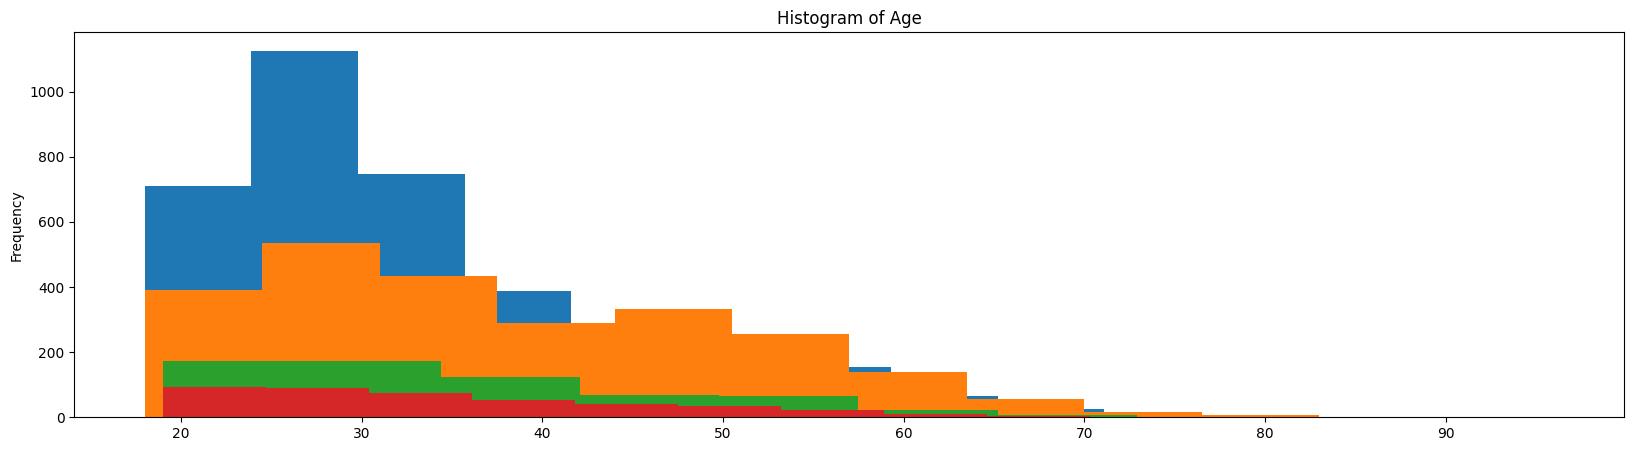

In [49]:
# Age is not very skewed
compas_df.groupby('race')['age'].plot(
    figsize=(20, 5),
    kind='hist', xlabel='Age', title='Histogram of Age'
)

compas_df.groupby('race')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,4.438853,5.579835,0.0,1.0,2.0,6.0,38.0
Caucasian,2454.0,2.586797,3.798803,0.0,0.0,1.0,3.0,36.0
Hispanic,637.0,2.252747,3.647673,0.0,0.0,1.0,2.0,26.0
Other,427.0,2.016393,3.695856,0.0,0.0,1.0,2.5,31.0


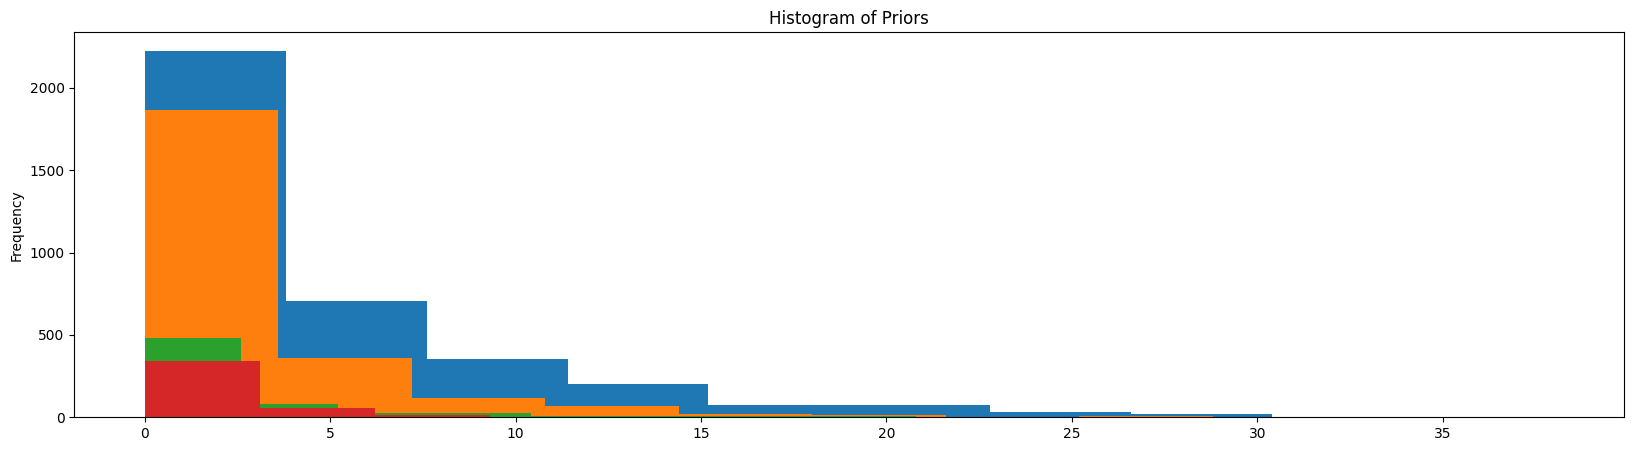

In [51]:
# Prior is extremely skewed
compas_df.groupby('race')['priors_count'].plot(
    figsize=(20, 5),
    kind='hist', xlabel='Count of Priors', title='Histogram of Priors'
)

compas_df.groupby('race')['priors_count'].describe()

### Applying Yeo-Johnson 

In [52]:
'''
for each group label:
    Get the subset of priors_counts values for that group
    Apply the yeo-johnson transformation to the subset
    Modify the column in place for that group label with the new values
'''

'\nfor each group label:\n    Get the subset of priors_counts values for that group\n    Apply the yeo-johnson transformation to the subset\n    Modify the column in place for that group label with the new values\n'

In [54]:
class NormalizeColumnByLabel(BaseEstimator, TransformerMixin):
    def __init__(self, col, label):
        self.col = col
        self.label = label
        self.transformers = {}
        
    def fit(self, X, y=None):
        for group in X[self.label].unique():
            self.transformers[group] = PowerTransformer(
                method='yeo-johnson', standardize=True
            )
            self.transformers[group].fit(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return self
    
    def transform(self, X, y=None):
        C = X.copy()
        for group in X[self.label].unique():
            C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return C

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,2604.0,1.855488e-16,1.000192,-1.394037,-0.549932,-0.092417,0.784661,2.276224
Caucasian,1700.0,1.097162e-16,1.000294,-1.190914,-1.190914,-0.104396,0.733866,2.293665
Hispanic,457.0,-9.911838e-17,1.001096,-1.124116,-1.124116,0.098333,0.620238,2.060623
Other,288.0,6.013708e-17,1.001741,-0.921525,-0.921525,-0.921525,0.878567,1.871600


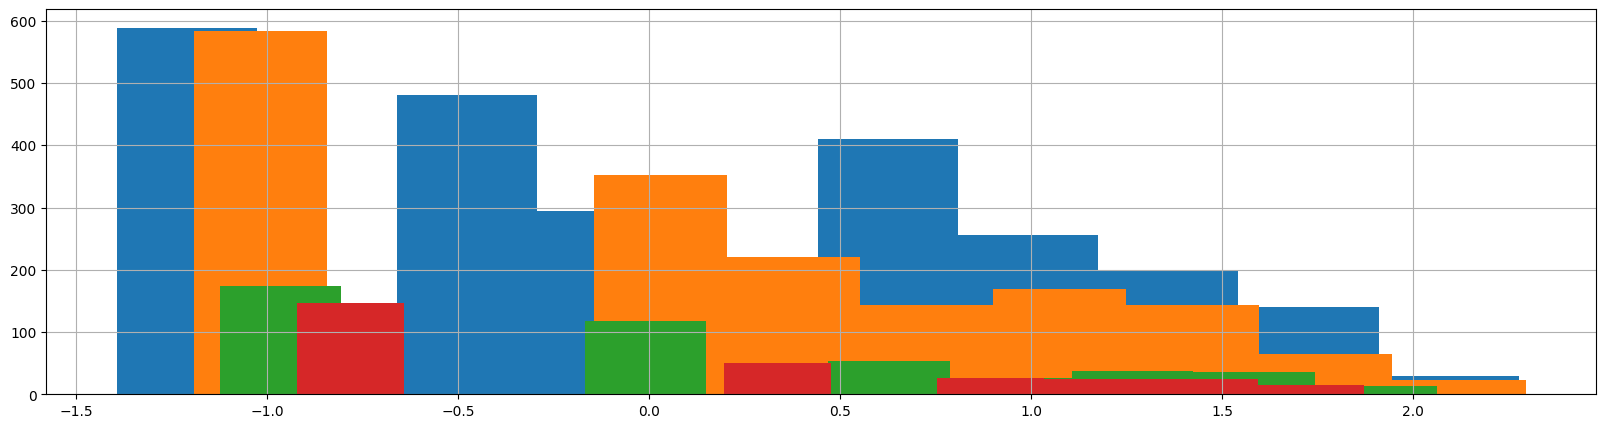

In [56]:
n = NormalizeColumnByLabel(col='priors_count', label='race')

X_train_normalized = n.fit_transform(X_train, y_train)

X_train_normalized.groupby('race')['priors_count'].hist(figsize=(20,5))
X_train_normalized.groupby('race')['priors_count'].describe()

### 1st Bias Aware Model

In [57]:
clf_tree_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

clf_tree_aware.fit(X_train, y_train)

aware_y_preds = clf_tree_aware.predict(X_test)

In [58]:
print(classification_report(y_true=y_test, y_pred=aware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.66      2165
   macro avg       0.65      0.65      0.65      2165
weighted avg       0.65      0.66      0.65      2165



In [59]:
# Checking out Model's Performance
exp_tree_aware = dx.Explainer(clf_tree_aware, X_test, y_test, label='Random Forest DIR', verbose=False)
mf_tree_aware = exp_tree_aware.model_fairness(protected=race_test, privileged = "Caucasian")

# Performance is virtually unchanged overall
pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware]])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199


In [60]:
mf_tree.plot(objects=[mf_tree_aware], type='stacked')

In [61]:
mf_tree_aware.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.680798  1.035881  1.148464  1.779487  1.849462
Hispanic          0.930175  1.048362  0.853242  0.933333  0.874552
Other             1.194514  1.021841  0.853242  1.297436  1.186380


### Custom LFR Transformer

In [68]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset

In [69]:
class LFRCustom(BaseEstimator, TransformerMixin):
    def __init__(self, col, protected_col, unprivileged_groups, privileged_groups):
        self.col = col
        self.protected_col = protected_col
        self.TR = None
        self.unprivileged_groups = unprivileged_groups
        self.privileged_groups = privileged_groups
        
    def fit(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        d['response'] = list(y)

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col, 
            label_names=['response']
        )

        # Input reconstruction quality - Ax
        # Output prediction error - Ay
        # Fairness constraint - Az

        self.TR = LFR(unprivileged_groups=self.unprivileged_groups,
                 privileged_groups=self.privileged_groups, seed=0,
                 k=2, Ax=0.5, Ay=0.2, Az=0.2,
                 verbose=1
                )
        self.TR.fit(binary_df, maxiter=5000, maxfun=5000)
        return self

    
    def transform(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        if y:
            d['response'] = list(y)
        else:
            d['response'] = False

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col, 
            label_names=['response']
        )
        return self.TR.transform(binary_df).convert_to_dataframe()[0].drop(['response'], axis=1)

### Pipeline Modifications

- Using FeatureUnion

In [70]:
categorical_preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
])

# Right now the aif360 package can only support one privileged and one unprivileged group
privileged_groups = [{'Caucasian': 1}]
unprivileged_groups = [{'Caucasian': 0}]


lfr = LFRCustom(
    col=['African-American', 'Caucasian', 'Hispanic', 'Other', 'Male', 'M'], 
    protected_col=sorted(X_train['race'].unique()) ,
    privileged_groups=privileged_groups, 
    unprivileged_groups=unprivileged_groups
)

categorical_pipeline = Pipeline([
    ('transform', categorical_preprocessor),
    ('LFR', lfr),
])

numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

numerical_preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features)
])

preprocessor = FeatureUnion([
    ('numerical_preprocessor', numerical_preprocessor),
    ('categorical_pipeline', categorical_pipeline)
])

In [71]:
clf_tree_more_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


clf_tree_more_aware.fit(X_train, y_train)

more_aware_y_preds = clf_tree_more_aware.predict(X_test)

step: 0, loss: 0.5113461179394596, L_x: 0.6910353031396581,  L_y: 0.750554787675951,  L_z: 0.07858754417220154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11346D-01    |proj g|=  1.09928D-01

At iterate    1    f=  4.46431D-01    |proj g|=  9.33491D-02

At iterate    2    f=  3.06498D-01    |proj g|=  5.18819D-02

At iterate    3    f=  3.03641D-01    |proj g|=  4.65203D-02

At iterate    4    f=  3.00521D-01    |proj g|=  5.46340D-02

At iterate    5    f=  3.00306D-01    |proj g|=  4.84318D-02

At iterate    6    f=  2.99620D-01    |proj g|=  4.82550D-02

At iterate    7    f=  2.98751D-01    |proj g|=  5.28487D-02

At iterate    8    f=  2.94627D-01    |proj g|=  5.02629D-02

At iterate    9    f=  2.89312D-01    |proj g|=  5.09962D-02

At iterate   10    f=  2.80357D-01    |proj g|=  4.56142D-02

At iterate   11    f=  2.65464D-01    |

In [72]:
print(classification_report(y_true=y_test, y_pred=more_aware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.74      0.71      1189
           1       0.64      0.56      0.60       976

    accuracy                           0.66      2165
   macro avg       0.66      0.65      0.65      2165
weighted avg       0.66      0.66      0.66      2165



In [73]:
exp_tree_more_aware = dx.Explainer(clf_tree_more_aware, X_test, y_test, label='Random Forest DIR + LFR', verbose=False)

mf_tree_more_aware = exp_tree_more_aware.model_fairness(protected=race_test, privileged="Caucasian")

pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware, exp_tree_more_aware]])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199
Random Forest DIR + LFR,0.558402,0.639671,0.596280,0.659122,0.693417


In [74]:
mf_tree.plot(objects=[mf_tree_aware, mf_tree_more_aware], type='stacked')

In [75]:
# Recidivism by race in our test set
print(y_test.groupby(race_test).mean())

# Predicted Recidivism by race in our bias-unaware model
pd.Series(more_aware_y_preds, index=y_test.index).groupby(race_test).mean()

race
African-American    0.514652
Caucasian           0.407162
Hispanic            0.327778
Other               0.345324
Name: two_year_recid, dtype: float64


race
African-American    0.500000
Caucasian           0.291777
Hispanic            0.261111
Other               0.280576
dtype: float64

In [76]:
# 7 / 15 numbers out of the range of (08, 1.25)
mf_tree.fairness_check()

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.633907  1.035994  1.160069  1.701493  1.782456
Hispanic          0.874693  1.007825  0.769363  1.069652  0.915789
Other             1.380835  1.035994  0.876076  1.422886  1.336842


In [77]:
# 4 / 15 numbers out of the range of (08, 1.25)
mf_tree_aware.fairness_check()  

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.680798  1.035881  1.148464  1.779487  1.849462
Hispanic          0.930175  1.048362  0.853242  0.933333  0.874552
Other             1.194514  1.021841  0.853242  1.297436  1.186380


In [78]:
# 3 / 15 numbers out of the range of (08, 1.25)
mf_tree_more_aware.fairness_check()  

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.626829  1.058268  1.198953  1.538095  1.712329
Hispanic          1.075610  1.102362  0.965096  0.828571  0.893836
Other             0.914634  0.996850  0.806283  1.100000  0.962329


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2cff3417-3a50-48e7-97b6-7b4d4ae634d4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>